In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Context

In [2]:
train = pd.read_csv('train.csv')
train.info()
print(train.describe())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          96708 non-null   float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         99866 non-null   float64
 10  Cabin        32134 non-null   object 
 11  Embarked     99750 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 7.2+ MB
         PassengerId       Survived         Pclass           Age  \
count  100000.000000  100000.000000  100000.000000  96708.000000   
mean    49999.500000       0.427740       2.106910     38.355472   
std     28867.657797  

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


# Data quality assessment

PassengerId        0
Survived           0
Pclass             0
Name               0
Sex                0
Age             3292
SibSp              0
Parch              0
Ticket          4623
Fare             134
Cabin          67866
Embarked         250
dtype: int64

PassengerId - 0.0%
Survived - 0.0%
Pclass - 0.0%
Name - 0.0%
Sex - 0.0%
Age - 3.29%
SibSp - 0.0%
Parch - 0.0%
Ticket - 4.62%
Fare - 0.13%
Cabin - 67.87%
Embarked - 0.25%

(100000, 11)
(100000, 11)
         PassengerId       Survived         Pclass           Age  \
count  100000.000000  100000.000000  100000.000000  100000.00000   
mean    49999.500000       0.427740       2.106910      38.35149   
std     28867.657797       0.494753       0.837727      18.03248   
min         0.000000       0.000000       1.000000       0.08000   
25%     24999.750000       0.000000       1.000000      25.00000   
50%     49999.500000       0.000000       2.000000      39.00000   
75%     74999.250000       1.000000       3.000000      53.00

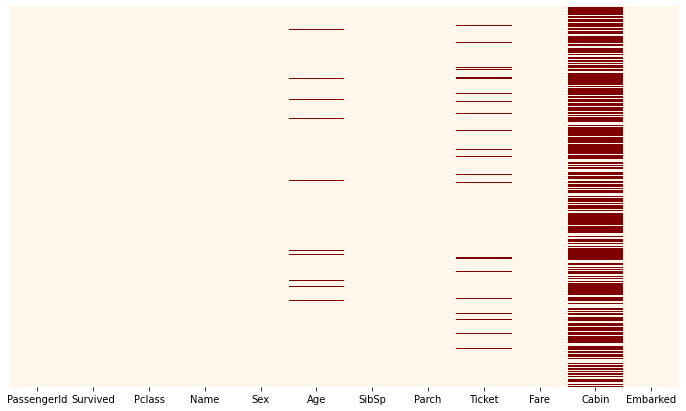

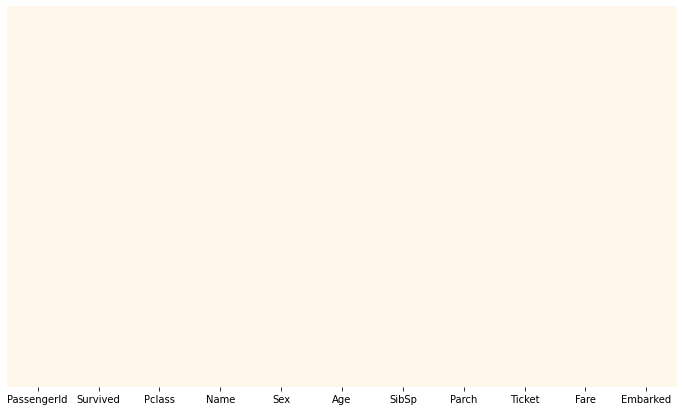

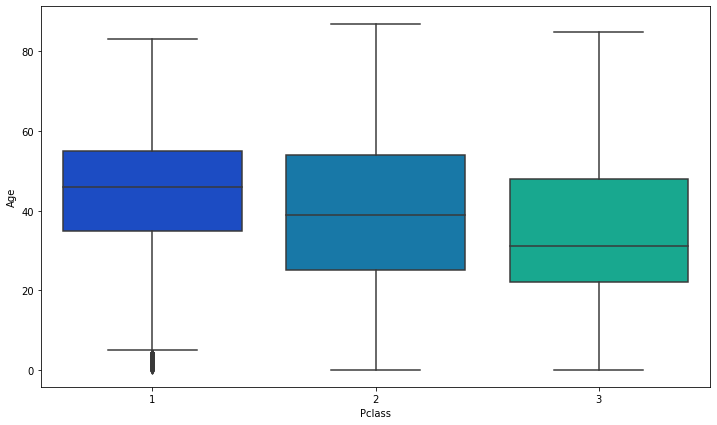

In [3]:
# 1. Анализ незаполненных данных
# 1.1. Количество незаполненных значений по столбцам
print(train.isnull().sum())
print()
# 1.2. Процент незаполненных значений по столбцам
for col in train.columns:
    pct_missing = np.mean(train[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100,2)))
print()
# 1.3. График незаполненных значений по столбцам
plt.figure(figsize=(12,7))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='OrRd')
# 1.4. Заполнение Age, Ticket, Fare, Embarked, Удаление Cabin
def input_Age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return 45
        elif Pclass == 2:
            return 39
        else:
            return 33
    return Age
train['Age'] = train[['Age','Pclass']].apply(input_Age,axis=1)
train['Ticket'] = train['Ticket'].fillna('000000')
f1 = round(train[train['Pclass']==1]['Fare'].mean(),2)
f2 = round(train[train['Pclass']==2]['Fare'].mean(),2)
f3 = round(train[train['Pclass']==3]['Fare'].mean(),2)

def input_Fare(cols, f1, f2, f3):
    Fare = cols[0]
    Pclass = cols[1]
    if pd.isnull(Fare):
        if Pclass == 1:
            return f1
        elif Pclass == 2:
            return f2
        else:
            return f3
    return Fare
train['Fare'] = train[['Fare','Pclass']].apply(input_Fare,axis=1, args=[f1,f2,f3])

def input_Embarked(col):
    Em = col[0]
    if pd.isnull(Em):
        return 'S'
    return Em
train['Embarked'] = train[['Embarked','Pclass']].apply(input_Embarked,axis=1)
train.drop('Cabin',axis=1,inplace=True)
# Проверка
plt.figure(figsize=(12,7))
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='OrRd')
# 1.5. 
# 2. Выбросы
plt.figure(figsize=(12,7))
sns.boxplot(x='Pclass',y='Age',data=train,palette='winter')
# Выбросов нет, в том числе после анализа describe()

# 3. Дубли
key = ['Ticket', 'Name','Age']
train_dedupped = train.drop_duplicates(subset=key)
print(train.shape)
print(train_dedupped.shape)
# Дубликатов по имени нет

# 4. Перевод категориальных переменных в числовые
# Пол
def is_male(sex):
    if sex == 'male':
        return 0
    else:
        return 1
# Порт отправления
def em_in_num(Em):
    if Em == 'S':
        return 0
    elif Em == 'C':
        return 1
    else:
        return 2
train['SexNum'] = train.apply(lambda x: is_male(x['Sex']), axis =  1)
train['EmbarkedNum'] = train.apply(lambda x: em_in_num(x['Embarked']), axis =  1)
print(train.describe())


# Data exploration

42774
56114


c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


40.535822228456546
36.7187946038514


c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\admin\appdata\local\programs\python\python38-32\lib\site-packages\seaborn\categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


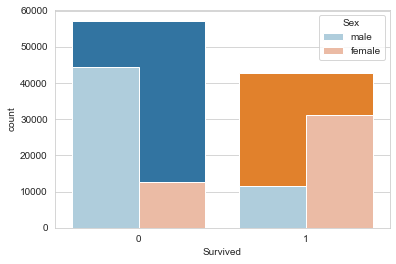

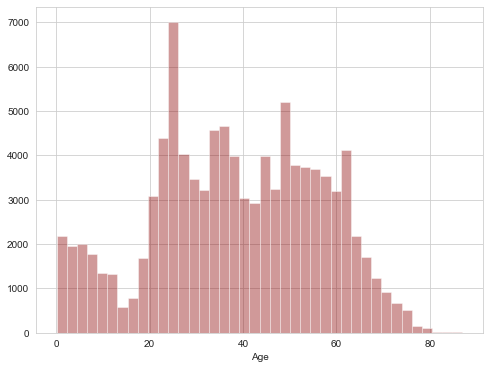

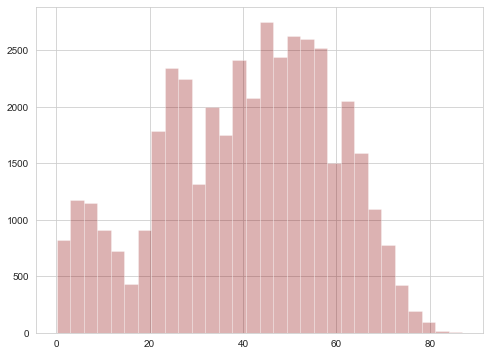

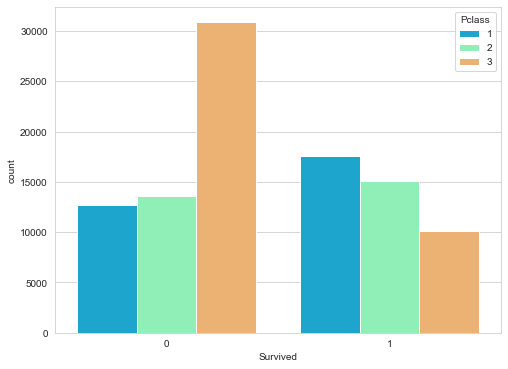

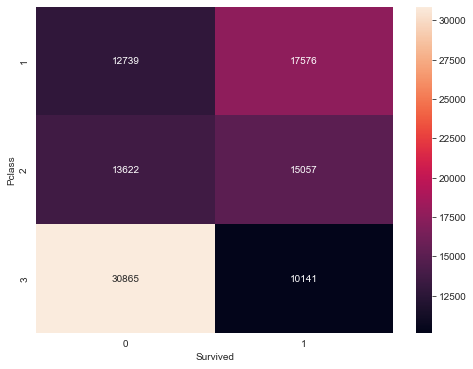

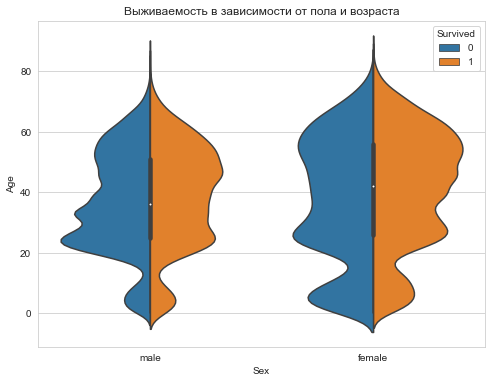

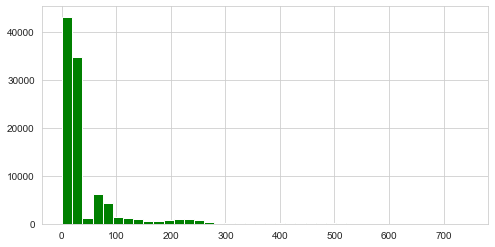

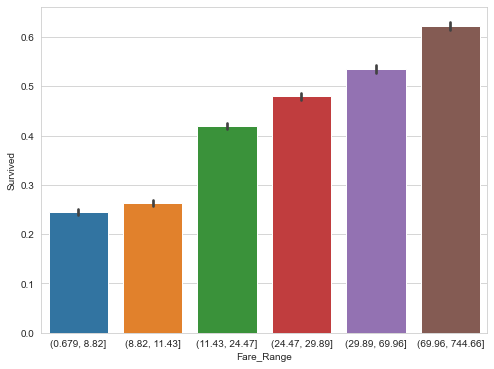

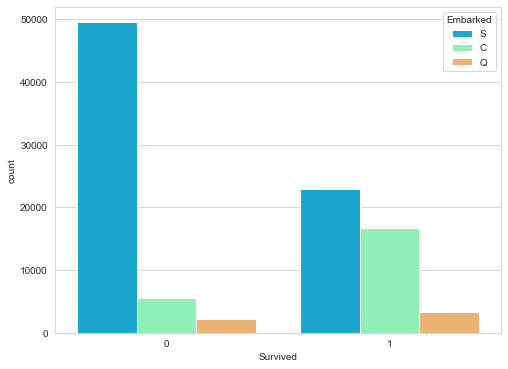

<Figure size 576x432 with 0 Axes>

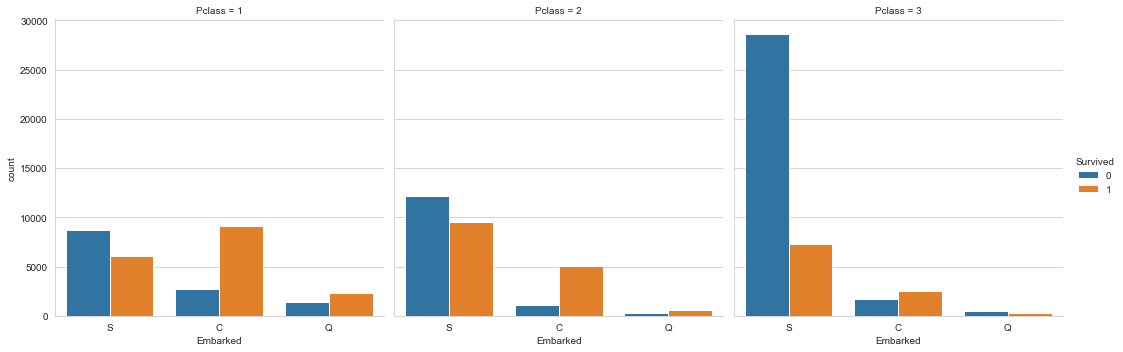

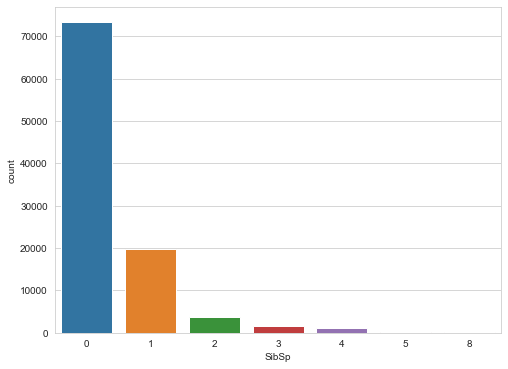

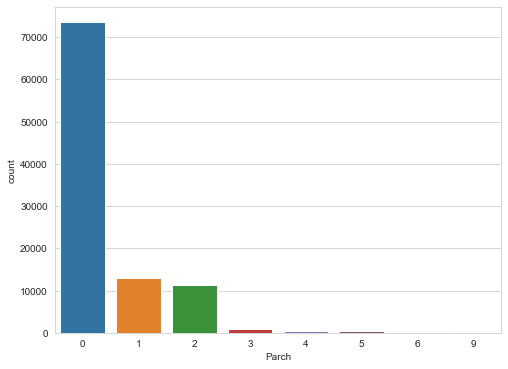

<Figure size 576x432 with 0 Axes>

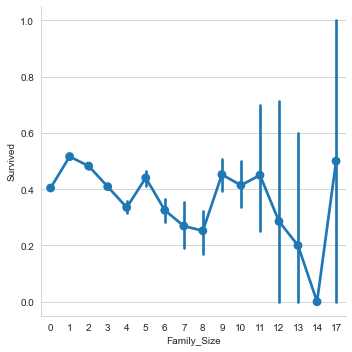

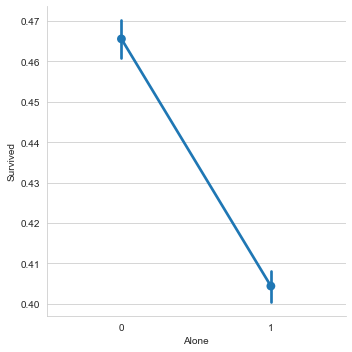

In [23]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=train); sns.countplot(x='Survived',hue='Sex', data=train,palette='RdBu_r')
print(train[train['Survived']==1].shape[0])
print(train[train['Sex']=='male'].shape[0])

# Возраст и пол
fig = plt.figure(figsize=(8, 6))
sns.distplot(train['Age'].dropna(),kde=False,color='darkred',bins=40)

# Возраст выжившего
fig = plt.figure(figsize=(8, 6))
train[train['Survived']==1]['Age'].hist(bins=30,color='darkred',alpha=0.3)
print(train[train['Survived']==1]['Age'].mean())
print(train[train['Survived']!=1]['Age'].mean())

# Класс каюты
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8, 6))
sns.countplot(x='Survived',hue='Pclass', data=train,palette='rainbow')

fig = plt.figure(figsize=(8, 6))
group = train.groupby(['Pclass', 'Survived'])
pclass_survived = group.size().unstack()
sns.heatmap(pclass_survived, annot = True, fmt ="d")

fig = plt.figure(figsize=(8, 6))
sns.violinplot(x ="Sex", y ="Age", hue ="Survived", data = train, split = True)

# Стоимость билета
fig = plt.figure(figsize=(8, 6))
train['Fare'].hist(color='green',bins=40,figsize=(8,4))

# Стоимость билета
fig = plt.figure(figsize=(8, 6))
train['Fare_Range'] = pd.qcut(train['Fare'], 6)
sns.barplot(x ='Fare_Range', y ='Survived', data = train)

# Порт
fig = plt.figure(figsize=(8, 6))
sns.set_style('whitegrid')
sns.countplot(x='Survived', hue='Embarked', data=train,palette='rainbow')

fig = plt.figure(figsize=(8, 6))
sns.catplot(x ='Embarked', hue ='Survived', kind ='count', col ='Pclass', data = train)

# Семья - братья и сестры
fig = plt.figure(figsize=(8, 6))
sns.countplot(x='SibSp',data=train)

# Семья - родители
fig = plt.figure(figsize=(8, 6))
sns.countplot(x='Parch',data=train)

# Семья
fig = plt.figure(figsize=(8, 6))
# Количество членов семьи
train['Family_Size'] = 0
train['Family_Size'] = train['Parch']+train['SibSp']
 
# Человек путешествует один
train['Alone'] = 0
train.loc[train.Family_Size == 0, 'Alone'] = 1
 
sns.factorplot(x ='Family_Size', y ='Survived', data = train)
sns.factorplot(x ='Alone', y ='Survived', data = train)



# Summary

In [5]:
# Из 100 тыс. человек выжило 42774 (42.77%)
# Путешествовало 56114 мужчин (56.11%), и 43886 женщин (43.89%)
# Из 56114 мужсин выжило 11548 (20.58%)
# Из 43886 жещин выжило 31226 (71.15%)
# Вероятность выжить женщине была намного выше, чем мужчине
# Больше всего пассажиров было от 24 до 26 лет
# Средний возвраст выжившего 40.5 лет
# Средний возраст выжившего мужчины 38.7 лет, погибшего - 36.6
# Средний возраст выжившей женщины 41.2 года, погибшей - 37.0
# Мужчины от 20 до 30 лет гибличаще, чем мужчины другого возраста
# Женщины около 50 лет выживали чаще, чем другого возраста, девочки около 5 лет гибли чаще, чем выживали
# Распределение по классам:
# Пассажиров 1-го класса - 30315 (30.3%), 2-го - 28679 (28.7%), 3-го - 41006 (41.0%) 
# Выжило 57.97% пассажиров 1-го класса (17576 из 30315)
# Выжило 52.5% пассажиров 2-го класса (15057 из 28679)
# Выжило 24.7% пассажиров 3-го класса (10141 из 41006)
# Если семья больше 5 человек, шансы выжить уменьшаются
# Вероятность выжить выше (0,45) , если пассажир ехал с семьей (0,405)
# Чем выше стоимость билета, тем выживаемость выше
# Саутгемптон-S—Шербур-C—Квинстаун-Q
# Большинство пассажиров отправлялись из Саунтгемптона, пэтому недатающие згачения были заполнены S.
# Выжило много пасажиров 1-го и 2-го класса, которые сели в порту C. Погибло очень много пассажиров 3-го класса, севших в порту S
# Общая стоимость проданных билетов 4 387 046.51
# Средняя стоимость билета - 43.92 по классам: 1 - 92.65, 2-25.75 , 3 - 20.61